In [3]:
import numpy as np
import networkx as nx
import random
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd

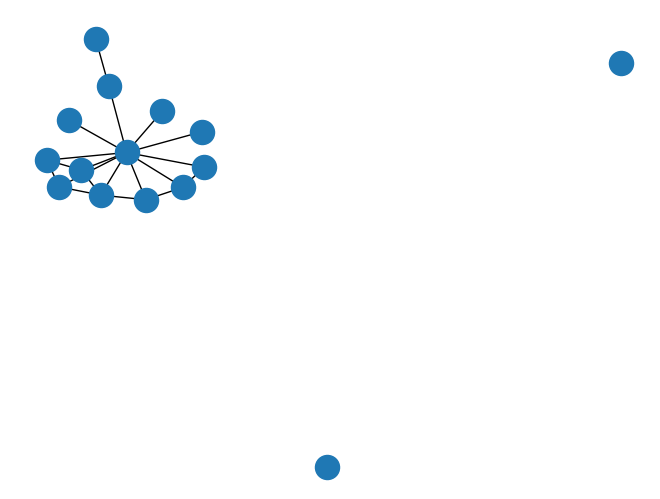

In [4]:
def chung_lu_sampler(sequence : list) -> nx.Graph : 
    """
    This function generates a random graph using the Chung-Lu algorithm. The algorithm takes in a sequence of 
    integers representing the desired degree sequence of the generated graph, and returns a networkx Graph object 
    that is the result of running the algorithm.
    
    Args:
    - sequence: A list of integers representing the degree sequence of the desired graph. The length of the 
                sequence determines the number of nodes in the graph.
    
    Returns:
    - g: A networkx Graph object that has the given degree sequence.
    
    Raises:
    - ValueError: If the product of any pair of degrees in the given sequence is greater than the sum of all 
                  degrees in the sequence.
    """
    # Sum of degrees
    mu = np.sum(sequence)
    g = nx.Graph()
    g.add_nodes_from([node for node in range(len(sequence))])
    #for every pair of indices in the sequence
    for index1, index2 in combinations(list(g.nodes()), 2):
        #pull degrees from indices
        ki, kj = sequence[index1], sequence[index2]
        #calculate p & set bound
        if (ki * kj) / mu > 1:
            raise ValueError('Invalid degree sequence')
        #random edge
        if np.random.rand() <= ((ki * kj) / mu):
            g.add_edge(index1, index2)
    g.remove_edges_from(nx.selfloop_edges(g))
    return g

g = chung_lu_sampler([5,2,3,3,4,3,2,2,2,2,5,5,2,2,10])
nx.draw(g)

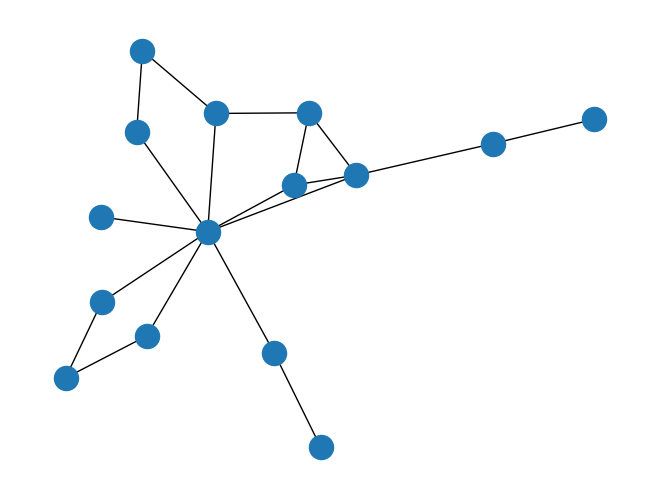

In [5]:
def mcmc_sampler(sequence: list, iterations: int) -> nx.Graph:
    """
    Args:
    - sequence: A list of integers representing the degree sequence of the desired graph. The length of the 
                sequence determines the number of nodes in the graph.
    - iterations: An integer representing the number of iterations to run the Markov Chain Monte Carlo algorithm for.
    
    Returns:
    - g: A networkx Graph object that has the given degree sequence.
    
    Raises:
    - ValueError: Checks to make sure random edges actually exist.
    """
    # INITIALIZE
    g = nx.havel_hakimi_graph(sequence)
    # ITERATE ALGORITHM
    for i in range(iterations):
        edges = list(g.edges())
        # PICK DOUBLE EDGE SWAP
        edge_a = random.choice(edges)
        edge_b = random.choice(edges)
        while edge_b == edge_a:
            edge_b = random.choice(edges)

        a1, a2 = edge_a[0], edge_a[1]
        b1, b2 = edge_b[0], edge_b[1]

        # CHECK IF EDGES EXIST
        if not g.has_edge(a1, a2) or not g.has_edge(b1, b2):
            raise ValueError('Invalid Sequence')
        else:
            # APPLY SWAP IF EDGE DOES NOT EXIST
            if g.has_edge(a1, b2) or g.has_edge(a2, b1):
                continue  # skip if edge already exists
            else:
                g.remove_edge(a1, a2)
                g.remove_edge(b1, b2)
                if np.random.rand() > 0.5:
                    g.add_edge(a1, b2)
                    g.add_edge(a2, b1)
                else:
                    g.add_edge(a1, b1)
                    g.add_edge(a2, b2)
    g.remove_edges_from(nx.selfloop_edges(g))
    return g


g = mcmc_sampler([5,2,3,3,4,3,2,2,2,2,5,5,2,2,10],100)
nx.draw(g)

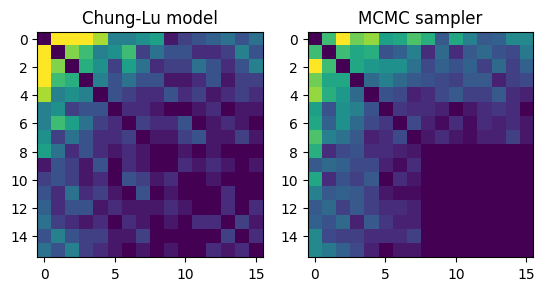

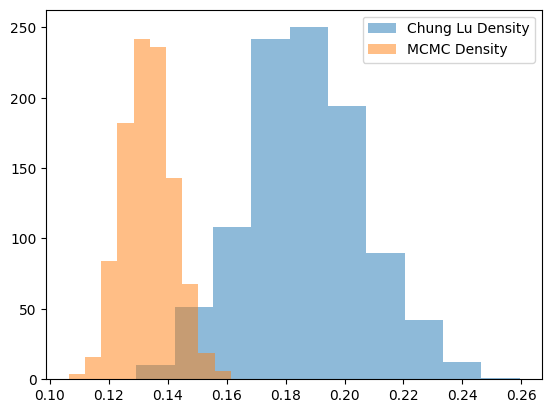

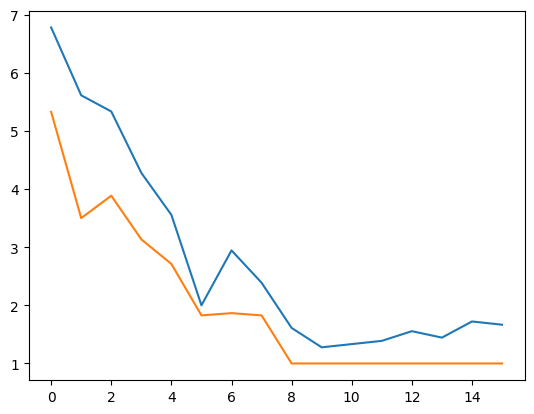

In [47]:
degrees = [7, 5, 5, 4, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]

# Generate random graphs using Chung-Lu model
num_graphs = 1000
cl_graphs = []
for i in range(num_graphs):
    g = chung_lu_sampler(degrees)
    if nx.is_connected(g):
        cl_graphs.append(g)

# Generate random graphs using MCMC sampler
num_iterations = 75 # adjust number of iterations to distribute nodes throughout network more/less
mcmc_graphs = []
for i in range(num_graphs):
    g = mcmc_sampler(degrees, num_iterations)
    if nx.is_connected(g):
        mcmc_graphs.append(g)

# Compute average adjacency matrix
cl_adj = np.zeros((len(degrees), len(degrees)))
for g in cl_graphs:
    cl_adj += nx.adjacency_matrix(g)
cl_adj /= num_graphs

mcmc_adj = np.zeros((len(degrees), len(degrees)))
for g in mcmc_graphs:
    mcmc_adj += nx.adjacency_matrix(g)
mcmc_adj /= num_graphs

# Plot average adjacency matrix
fig, axs = plt.subplots(1, 2)
axs[0].imshow(cl_adj)
axs[0].set_title('Chung-Lu model')
axs[1].imshow(mcmc_adj)
axs[1].set_title('MCMC sampler')
plt.show()

#Calculate average density
cl_density = [nx.density(g) for g in cl_graphs if nx.is_connected(g)]
mcmc_density = [nx.density(g) for g in mcmc_graphs if nx.is_connected(g)]

cl_d_mean = np.mean(cl_density)
cl_d_std = np.std(cl_density)

mcmc_d_mean = np.mean(mcmc_density)
mcmc_d_std = np.std(mcmc_density)

samples = 1000

x1 = np.random.normal(cl_d_mean, cl_d_std, samples)
x2 = np.random.normal(mcmc_d_mean, mcmc_d_std, samples)

plt.figure()
plt.hist(x1, alpha=0.5, label='Chung Lu Density')
plt.hist(x2, alpha=0.5, label='MCMC Density')
plt.legend(loc='upper right')
plt.show()

#Calculate average degree per node
cl_degree = [np.array(list(dict(nx.degree(g)).values())) for g in cl_graphs if nx.is_connected(g)]

avg_cl_degree = np.zeros(len(cl_degree[0]))
for i in range(len(cl_degree)):
    avg_cl_degree += cl_degree[i]
avg_cl_degree /= len(cl_degree)

mcmc_degree = [np.array(list(dict(nx.degree(g)).values())) for g in mcmc_graphs if nx.is_connected(g)]
avg_mcmc_degree = np.zeros(len(mcmc_degree[0]))
for i in range(len(mcmc_degree)):
    avg_mcmc_degree += mcmc_degree[i]
avg_mcmc_degree /= len(mcmc_degree)

plt.figure()
plt.plot(avg_cl_degree)
plt.plot(avg_mcmc_degree)
plt.show()


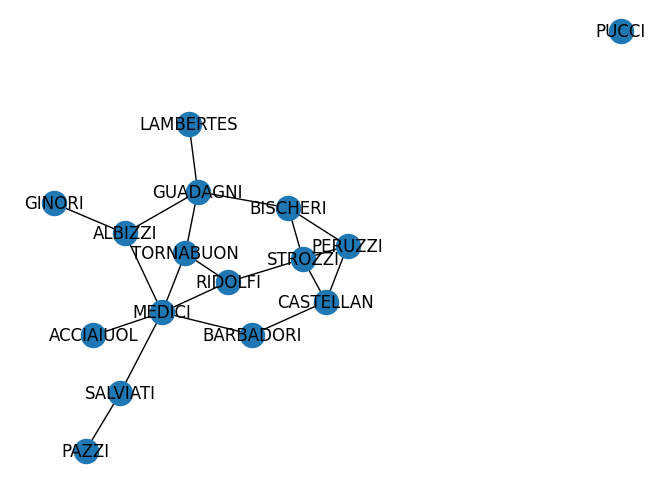

In [177]:
# Read CSV files
df_nodes = pd.read_csv('nodes.csv')
df_edges = pd.read_csv('edges.csv')

df_edges['# source']

df_edges = df_edges.rename(columns={'# source' : 'source', ' target' : 'target'})
df_edges = df_edges[df_edges[' layer'] == 1]
# Create empty graph
G = nx.from_pandas_edgelist(df_edges)
G.add_node(11)
#nx.draw(G)
#nx.set_node_attributes
df_nodes
nodes = {}
for i in range(len(df_nodes)):
    nodes[i] = df_nodes[' name'][i]
nx.set_node_attributes(G, nodes, 'name')
nx.draw(G,labels = nodes, with_labels = True)

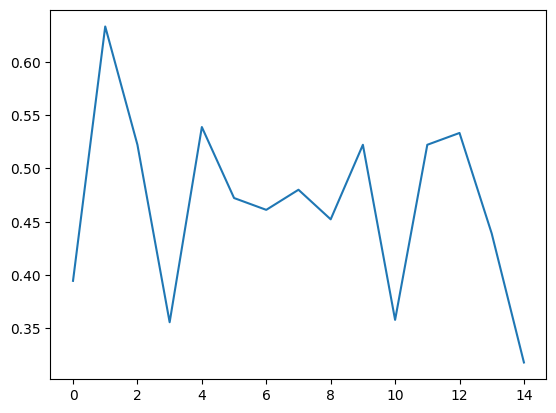

In [178]:
def harmonic_centrality(G : nx.Graph) -> list:
    shortest_paths_per_node = []
    inverse_sums = []
    nodes = len(G.nodes())

    for i in range(len(g.nodes())):
         if np.sum(list(nx.shortest_path_length(G))[i][1].values()) != 0: 
            shortest_paths_per_node.append(list(list(nx.shortest_path_length(G))[i][1].values()))  
    for l in shortest_paths_per_node:
        l.pop(0)
        inverse_distances = [1 / x for x in l]
        inverse_sums.append(np.sum(inverse_distances))
        
    return [(1 / (nodes - 1)) * s for s in inverse_sums]

zipped = zip(list(G.nodes()), harmonic_centrality(G))
plt.figure()
plt.plot(harmonic_centrality(G))
plt.show()

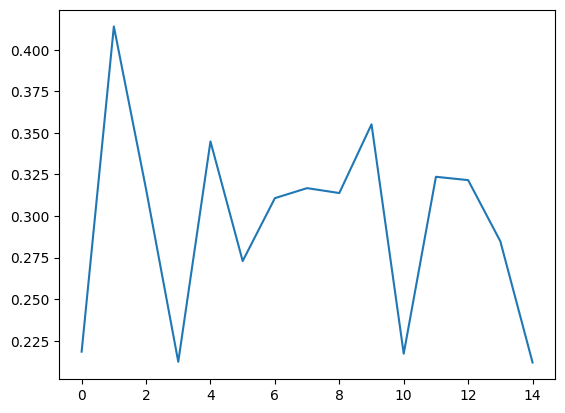

In [179]:
sequence = [i for i in dict(G.degree).values()]
num_graphs = 1000
iterations = 100

centralities_mcmc = np.zeros((len(sequence) - 1,))
for i in range(num_graphs):
    centralities_mcmc += np.array(harmonic_centrality(mcmc_sampler(sequence, iterations))) 
centralities_mcmc /= num_graphs
plt.figure()
plt.plot(centralities_mcmc)
plt.show()

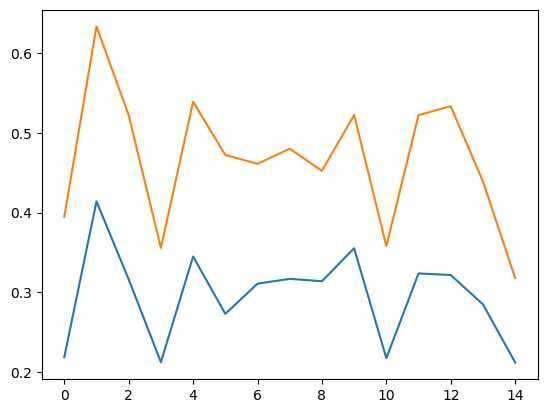

In [204]:
centralities = []
l = list(G)
for i in l:
    index = l.index(i)
    name = list(G.nodes()[i].values())
    if index < 15:
        centralities.append((name, centralities_mcmc[index], harmonic_centrality(G)[index] ))

plt.plot([l[1] for l in centralities])
plt.plot([l[2] for l in centralities])

In [16]:
def profile_log_likelihood(A : np.array, communities = np.array):
    """
    This function calculates the log likelihood of a given community assignment for a given adjacency matrix A. 

    Args:
    - A: A numpy array representing the adjacency matrix of the graph.
    - communities: A numpy array representing the community assignment of the nodes in the graph. The length 
                   of the array should be the same as the number of nodes in the graph.

    Returns:
    - log_likelihood: A float representing the log likelihood of the given community assignment for the given 
                      adjacency matrix.
    """
    log_likelihood = 0
    nodes = len(A)
    c = len(np.unique(communities))
    #initialize mixing matrix
    mrs = np.zeros((c, c))
    krs = np.zeros((c, ))
    #iterate through each row and col of matrix
    for i in range(c):
        for j in range(c):
            #iterate through each node twice
            for k in range(nodes):
                for l in range(nodes):
                    #Divide by two or else each entry in Adjacency Matrix is double counted
                    mrs[i][j] += A[k][l] / 2 if communities[k] == i and communities[l] == j else 0
        #krs = sum of mrs    
        krs[i] = np.sum(mrs[i])
    #Add log likelihoods from mixing matrix
    for i in range(c):
        for j in range(c):
            #Make sure move is allowed
            if (krs[i] * krs[j]) != 0 and mrs[i][j] != 0:
                log_likelihood += (mrs[i][j] * np.log(mrs[i][j] / (krs[i]*krs[j])) ) 
    log_likelihood  = log_likelihood / 2
    return log_likelihood
            
#Communitize function : creates random partition into two groups with a numpy array as a parameter
communitize = lambda A : np.array([1 if np.random.rand() < 0.5 else 0 for i in range(len(A))]) 

def optimize_communities(A: np.array, communities: np.array):
    """
    This function optimizes the community assignment for a given adjacency matrix A using the profile likelihood 
    method.

    Args:
    - A: A numpy array representing the adjacency matrix of the graph.
    - communities: A numpy array representing the initial community assignment of the nodes in the graph. The 
                   length of the array should be the same as the number of nodes in the graph.

    Returns:
    - best_communities: A numpy array representing the final community assignment of the nodes in the graph that 
                        maximizes the log likelihood.
    - max_likelihood: A float representing the maximum log likelihood value.
    - likelihoods: A dictionary that maps each log likelihood value to its corresponding community assignment.
    """
    #Initialize likelihoods dict and store current value
    likelihoods = {}
    best_communities = communities.copy()
    log_likelihood = profile_log_likelihood(A, best_communities)
    best_log_likelihood = log_likelihood
    likelihoods[log_likelihood] = best_communities
    #Initialize Node Sets
    frozen_nodes = set()
    free_nodes = set(i for i in range(len(best_communities)))
    while len(free_nodes) > 0:
        # Initialize the highest_delta and the corresponding node index
        highest_delta = None
        highest_delta_node = None
        for node in free_nodes.copy():
            # Create a new array to avoid modifying the original communities array
            new_communities = best_communities.copy()
            new_communities[node] = abs(best_communities[node] - 1)
            delta = profile_log_likelihood(A, new_communities) - log_likelihood
            # Update highest_delta and highest_delta_node if needed
            if highest_delta is None or abs(delta) > abs(highest_delta):
                highest_delta = delta
                highest_delta_node = node
            #Add likelihood to likelihoods dict
            likelihoods[profile_log_likelihood(A, new_communities)] = new_communities
        # Update the community assignment, log-likelihood, and move the node from free_nodes to frozen_nodes
        best_communities[highest_delta_node] = abs(best_communities[highest_delta_node] - 1)
        log_likelihood += highest_delta
        free_nodes.remove(highest_delta_node)
        frozen_nodes.add(highest_delta_node)
        #If LL is the current best, update best values
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            communities = best_communities.copy()

    # Find the maximum likelihood and the corresponding community assignment
    max_likelihood = max(likelihoods.keys())
    best_communities = likelihoods[max_likelihood]

    print(f"Best Log Likelihood : {max_likelihood}")
    #print(f"Best Community : {best_communities}")
    return best_communities, max_likelihood, likelihoods

In [17]:
karate = nx.karate_club_graph()
k_adj = nx.adjacency_matrix(karate)
k_array = k_adj.todense()
samples = 10
iterations = 20
max_likelihoods = []
all_likelihoods = []
best_partitions = []
for i in range(samples):
    print(f'Sample {i + 1}')
    C_partition = communitize(k_array)
    best_community_partition, max_likelihood_partition, likelihoods_partition = optimize_communities(k_array, C_partition)
    ll = 0
    for j in range(iterations):
        partition, max_likelihood, likelihoods = optimize_communities(k_array, best_community_partition)
        best_community_partition = partition
        if ll == max_likelihood:
            break
        ll = max_likelihood
        all_likelihoods.append(list(likelihoods.keys()))
    max_likelihoods.append(ll)
    best_partitions.append(best_community_partition)


Sample 1
Best Log Likelihood : -613.7892242314779
Best Log Likelihood : -609.5339698243374
Best Log Likelihood : -604.4572482279307
Best Log Likelihood : -599.3682754009474
Best Log Likelihood : -594.700365771813
Best Log Likelihood : -591.2743044195472
Best Log Likelihood : -588.1670339219656
Best Log Likelihood : -584.9817955533443
Best Log Likelihood : -584.9817955533442
Best Log Likelihood : -584.9817955533442
Sample 2
Best Log Likelihood : -622.4927563728443
Best Log Likelihood : -620.990646304243
Best Log Likelihood : -619.7289180377923
Best Log Likelihood : -617.8749674641007
Best Log Likelihood : -613.7144518762741
Best Log Likelihood : -607.5831440533218
Best Log Likelihood : -602.7617926666715
Best Log Likelihood : -597.7550755522699
Best Log Likelihood : -592.416557458132
Best Log Likelihood : -589.2905858852495
Best Log Likelihood : -586.039461793413
Best Log Likelihood : -584.9817955533442
Best Log Likelihood : -584.9817955533442
Sample 3
Best Log Likelihood : -623.6905042

Maximum log-likelihood mean: -599.3924737834001
Maximum log-likelihood std: 10.356836115776485


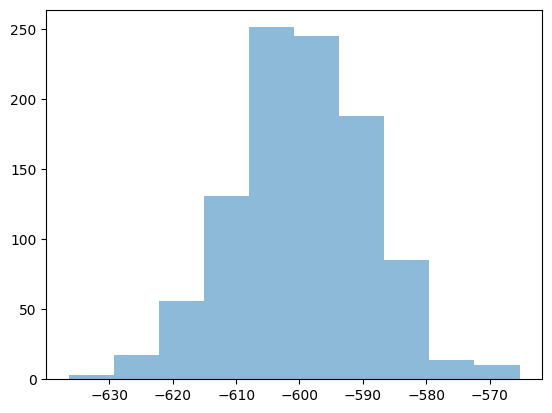

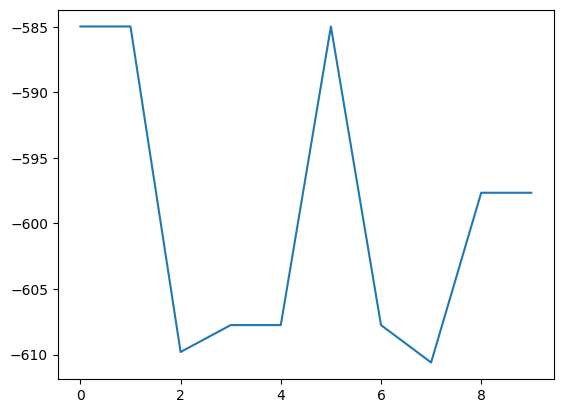

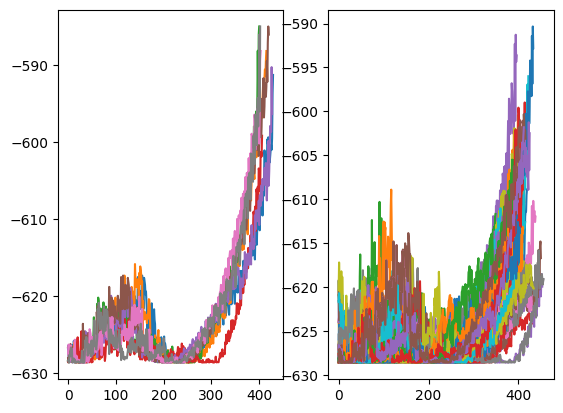

In [18]:
# Compute summary statistics
max_likelihoods = np.array(max_likelihoods)
max_likelihood_mean = np.mean(max_likelihoods)
max_likelihood_std = np.std(max_likelihoods)
# Print summary statistics
print(f'Maximum log-likelihood mean: {max_likelihood_mean}')
print(f'Maximum log-likelihood std: {max_likelihood_std}')

ml= np.random.normal(max_likelihood_mean, max_likelihood_std, 1000)

plt.figure()
plt.hist(ml, alpha=0.5, label='Community Detection Max Likelihood Distribution')
plt.show()

plt.figure()
plt.plot(list(max_likelihoods))
plt.show()

fig, axs = plt.subplots(1, 2)

best_likelihood_partitions = []
for i in range(len(all_likelihoods)):
    if np.max(all_likelihoods[i]) > -590 :
        best_likelihood_partitions.append(all_likelihoods[i])
        axs[0].plot(list(all_likelihoods[i])[75:])
    else:
        axs[1].plot(list(all_likelihoods[i])[75:])

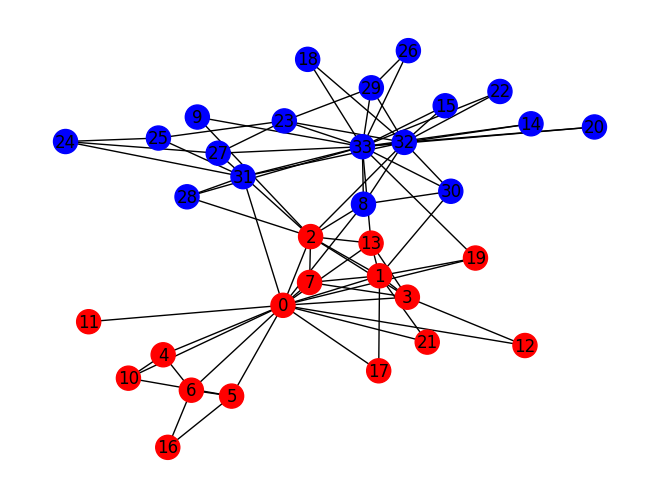

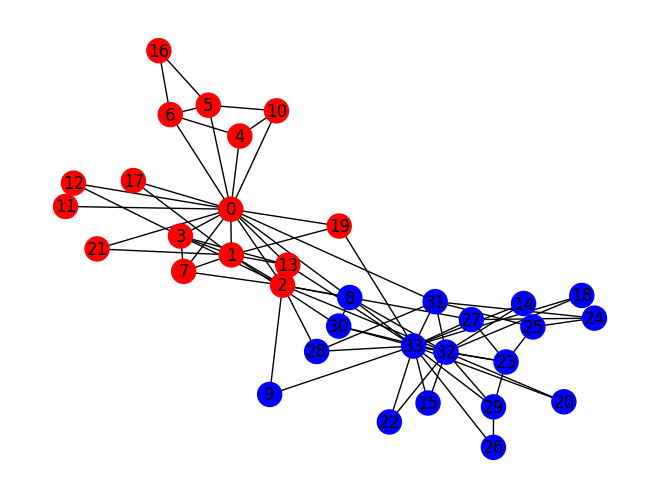

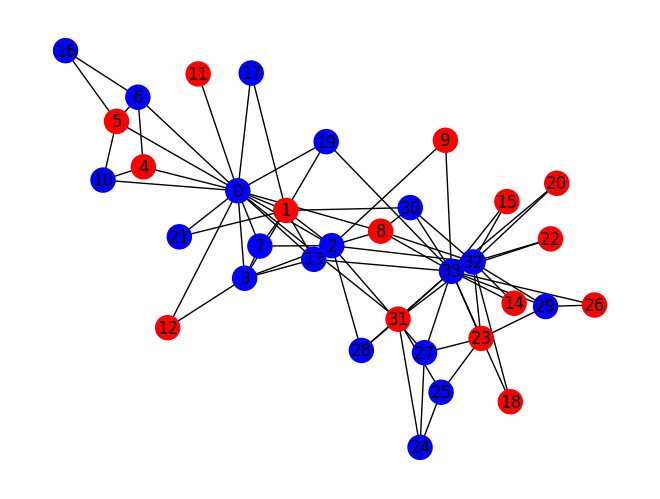

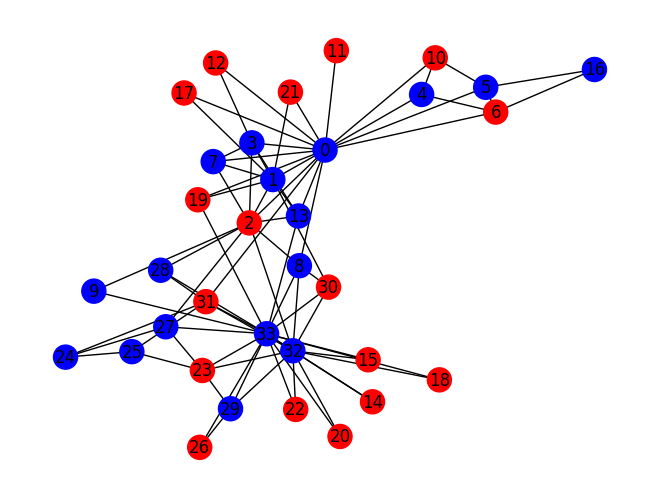

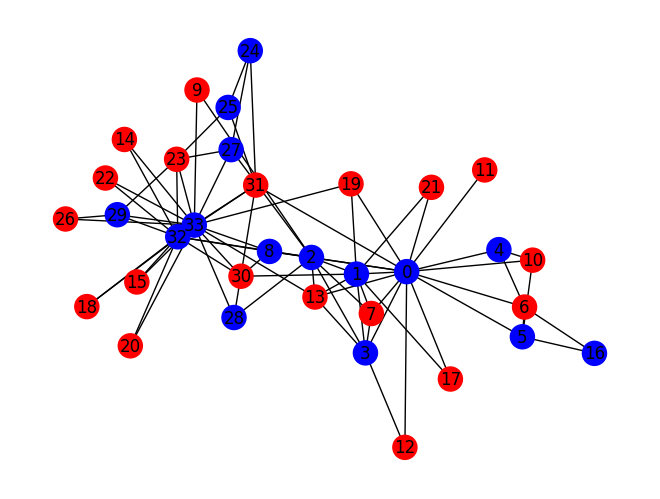

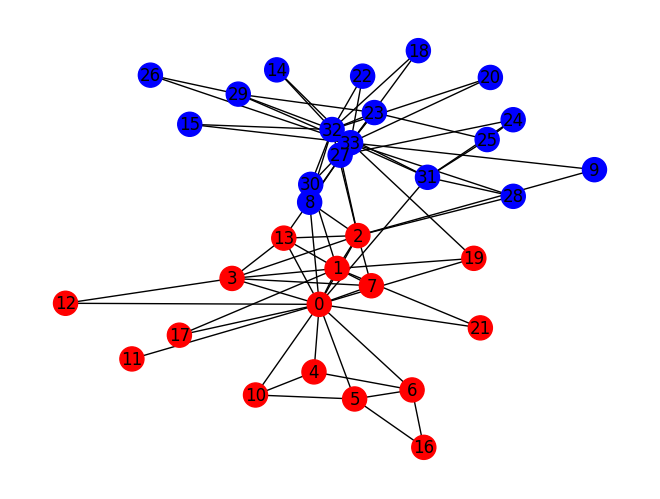

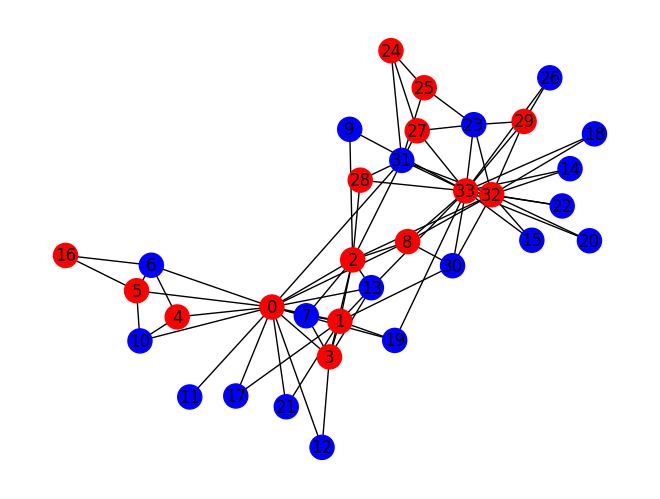

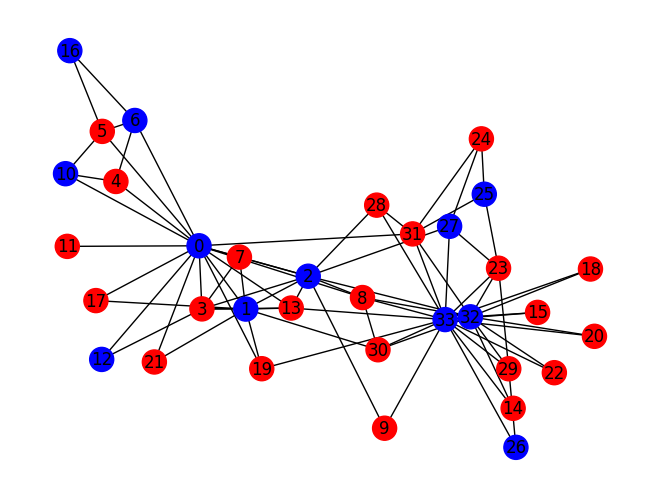

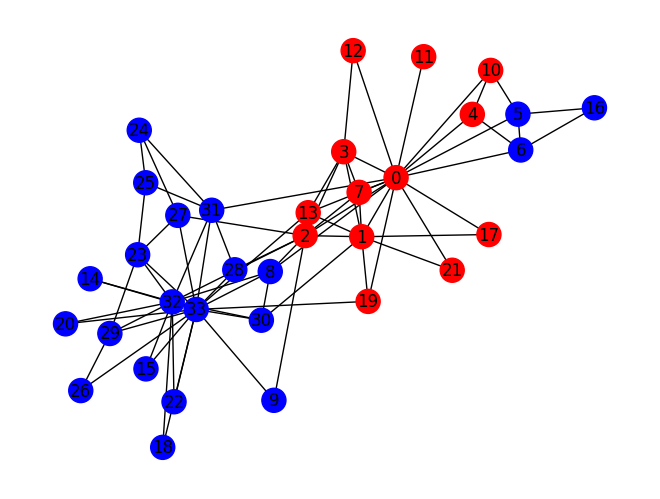

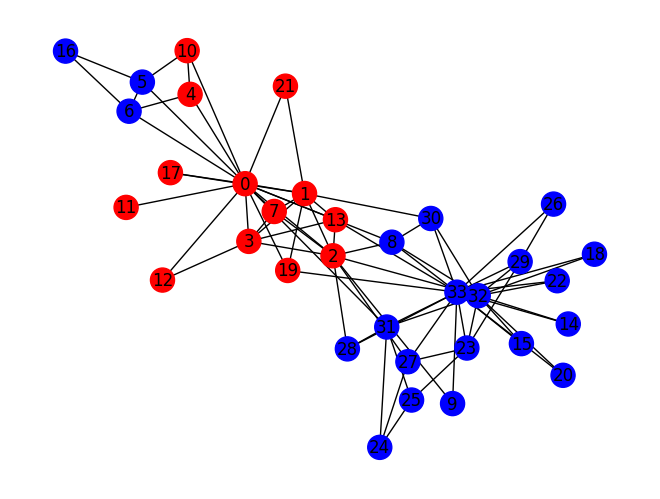

In [19]:
for best_community_partition in best_partitions:
    karatec = karate.copy()
    for i in range(len(best_community_partition)):
        karatec.nodes[i]['community'] = best_community_partition[i] 

    # Define the node colors based on their community
    color_map_partition = []
    for node in karatec.nodes():
        if karatec.nodes[node]['community'] == 1:
            color_map_partition.append('red')
        else:
            color_map_partition.append('blue')

    # Plot the graph
    plt.figure()
    pos = nx.spring_layout(karatec)
    nx.draw(karatec, pos, with_labels=True, node_color=color_map_partition)